## 04. Modelado con Machine Learning India

In [1]:
import warnings
from src.utils_functions import *
from src.features import *

# Display
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format
sns.set_theme(context='notebook', style=plt.style.use('dark_background'))
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# Modelado
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso
from glum import GeneralizedLinearRegressor
from sklearn.metrics import mean_absolute_error

# Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [3]:
# Carga y lectura de los datos
data = pd.read_excel('datasets\\raw\\Precios Litio.xlsx',
                     index_col=[0])

# Definimos la frecuencia de nuestras series temporales
data = data.asfreq('B')
data

,USD/Ton
Fecha,
2018-10-12,"11,268.0900"
2018-10-15,"11,276.5700"
2018-10-16,"11,284.8900"
2018-10-17,"11,259.4700"
2018-10-18,"11,242.7600"
...,...
2023-10-26,"22,450.9600"
2023-10-27,"22,314.4800"
2023-10-30,"22,317.7500"


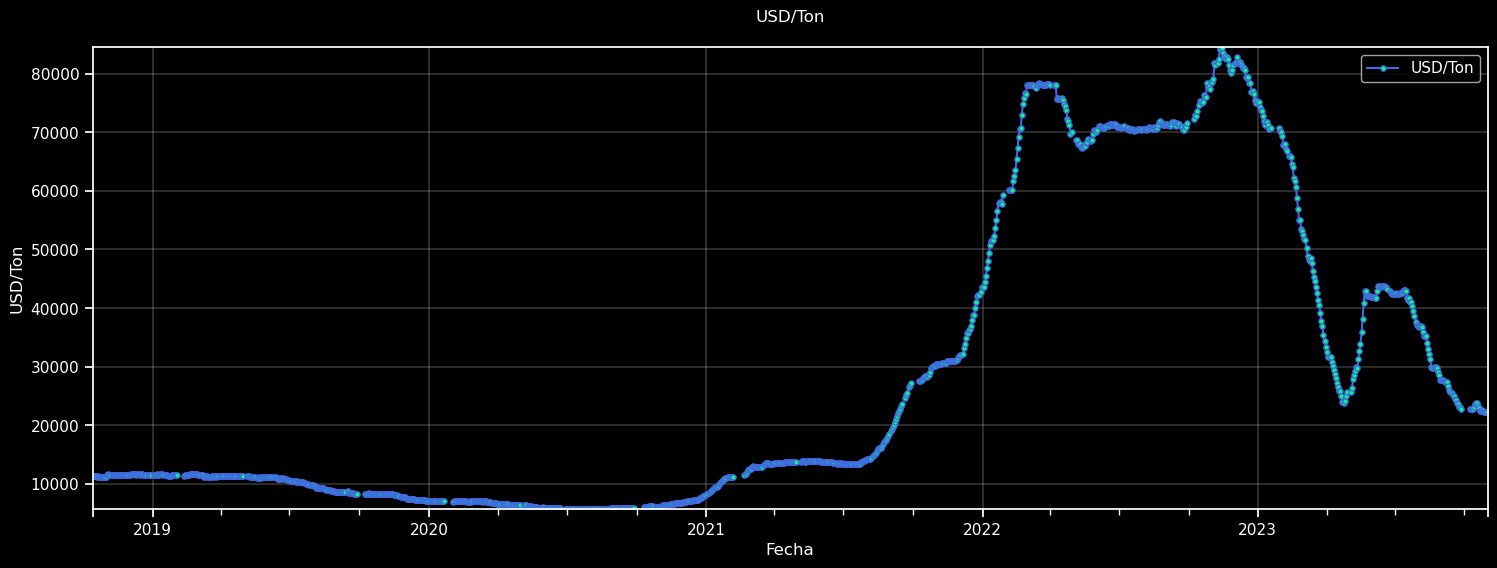

In [4]:
# Comportamiento de la serie
time_series_behavior(data=data, figsize=(18, 6))

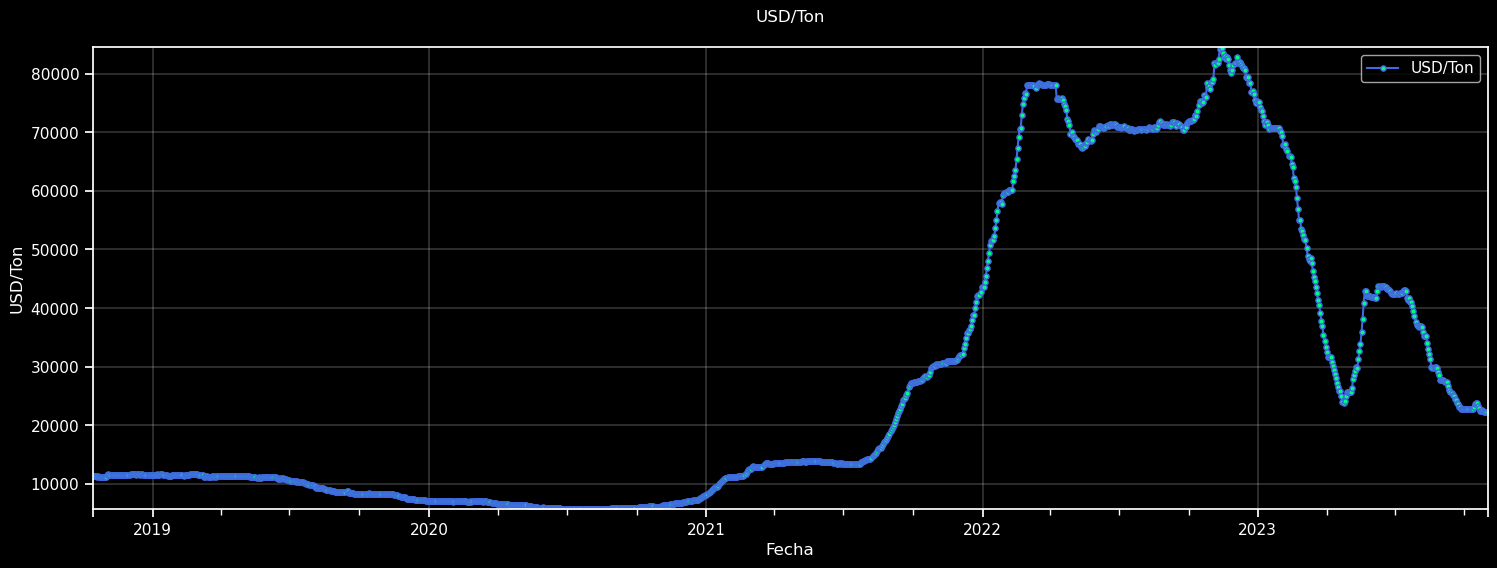

In [5]:
# Comportamiento de la serie interpolada
time_series_behavior(data=data.interpolate(method='time'), figsize=(18, 6))

# Realizar cambios
data = data.interpolate(method='time')

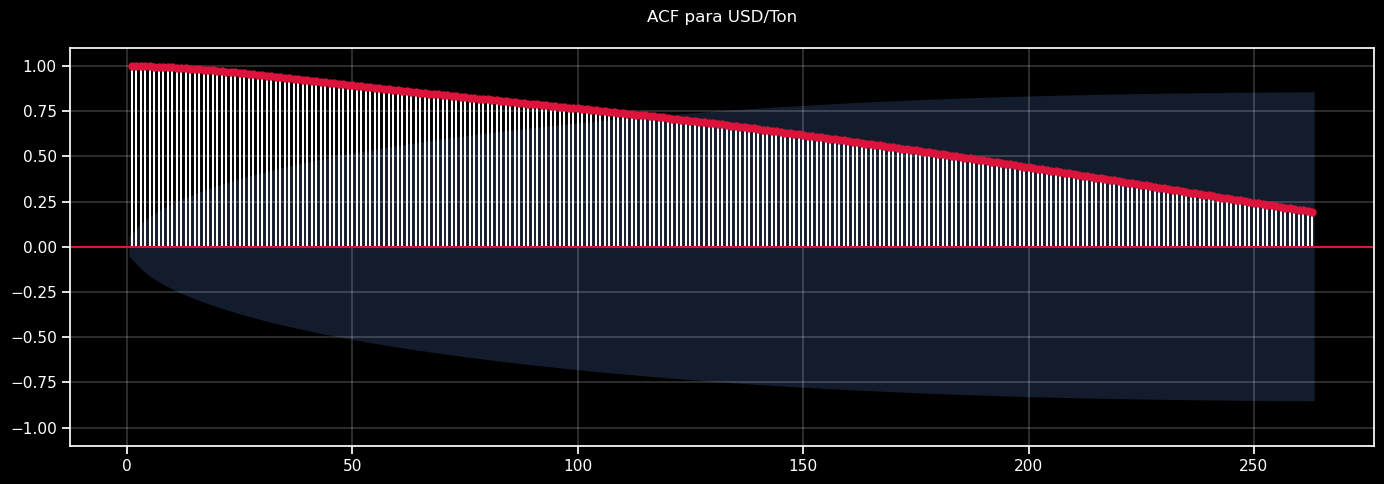

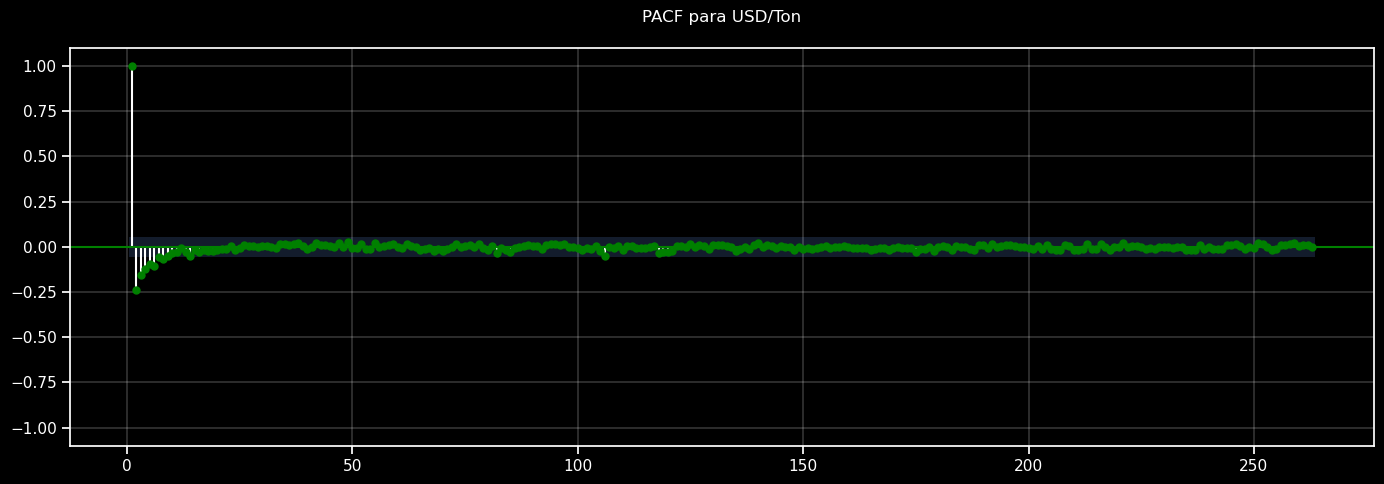

In [6]:
# Gráfico de función de autocorrelación y autocorrelación parcial
acf_y_pcf(data=data, lags=len(data)//5)

In [7]:
# Variables Generales
# ==============================================================================
target = 'USD/Ton'

# Punto de corte
fin_entrenamiento = data.iloc[int(data.shape[0]*0.8):].index[0]

## **Baseline - Simulación del Random Walk**

A la hora de generar un modelo predictivo es conveniente identificar un modelo de línea base, o baseline, sobre el que ir comparando cada una de las iteraciones o modelos propuestos. En el caso de las finanzas, acorde a la teoría del paseo aleatorio o Random Walk, los precios de mercado se comportan de manera aleatoria y no dependiente de su serie temporal. De esta manera, la mejor estimación para el valor $t_{n+1}$ es el valor $t_n$ más un cambio impredecible.

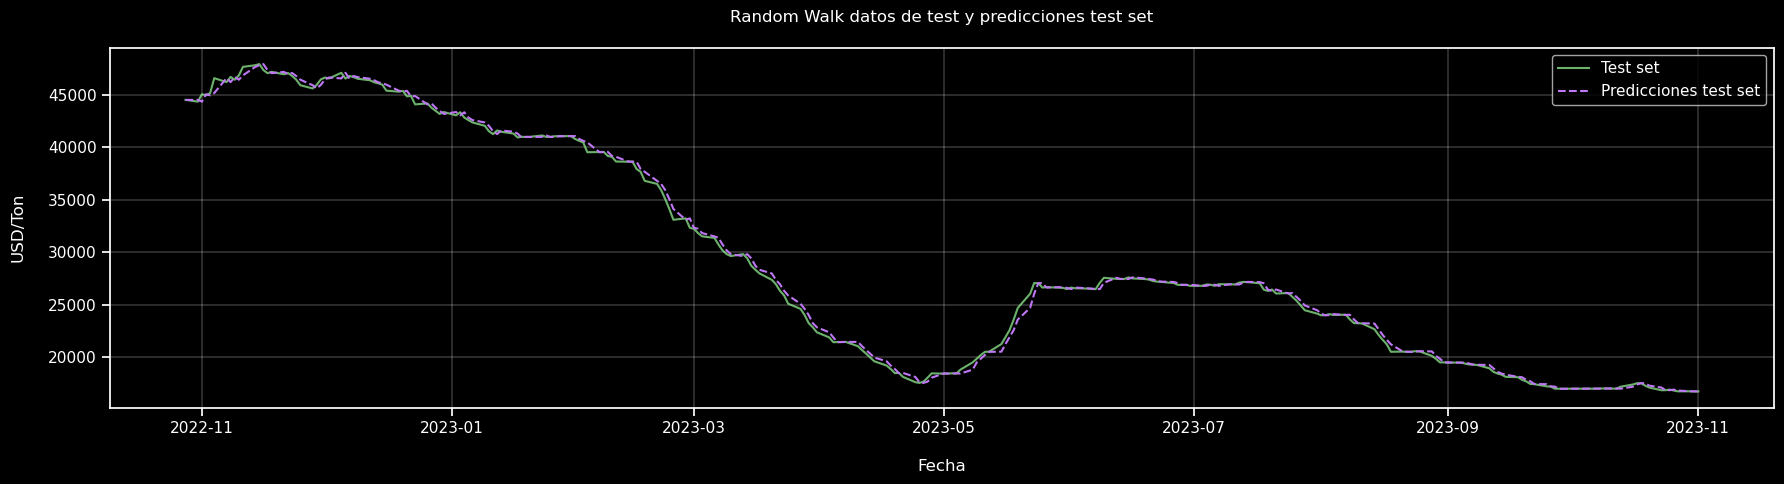

In [8]:
# Simulación Random Walk
# ==============================================================================
np.random.seed(42)
serie = data[target]

# Calculando las diferencias de la serie
diferencias = serie.diff().fillna(0)

# Introduciendo ruido a las diferencias
ruido = np.random.normal(loc=0.5, scale=0.001, size=len(diferencias))

# Construyendo el random walk a partir de la serie
random_walk = pd.DataFrame(serie.iloc[0] + diferencias.cumsum() * ruido, columns=[target])
random_walk['preds'] = random_walk[target].shift()

y_true = random_walk.loc[fin_entrenamiento:, target]
y_pred = random_walk.loc[fin_entrenamiento:, 'preds']

# Graficando
plt.figure(figsize=(18, 5))
plt.plot(y_true.index, y_true, label='Test set', color='lightgreen', alpha=0.75, linestyle='-')
plt.plot(y_pred.index, y_pred, label='Predicciones test set', color='xkcd:light purple', linestyle='dashed')
plt.title('Random Walk datos de test y predicciones test set\n')
plt.xlabel(f'\n{y_true.index.name}')
plt.ylabel(f'{y_true.name}\n')
plt.legend()
plt.grid(color='white', linestyle='-', linewidth=0.25)
plt.tight_layout()

In [9]:
# Dataframe de rendimiento del modelo de línea base
rendimiento = pd.DataFrame({
    'Modelo': 'Random Walk',
    'MAE': mean_absolute_error(y_true, y_pred),
    'MAPE': loss_function(y_true, y_pred)[0],
    'RMSE': loss_function(y_true, y_pred)[1],
    'RMSPE': loss_function(y_true, y_pred)[2],
    'R²': loss_function(y_true, y_pred)[3],
    'exog': [False]
})

rendimiento

,Modelo,MAE,MAPE,RMSE,RMSPE,R²,exog
0,Random Walk,261.7517,0.0094,370.6776,0.0134,0.9987,False


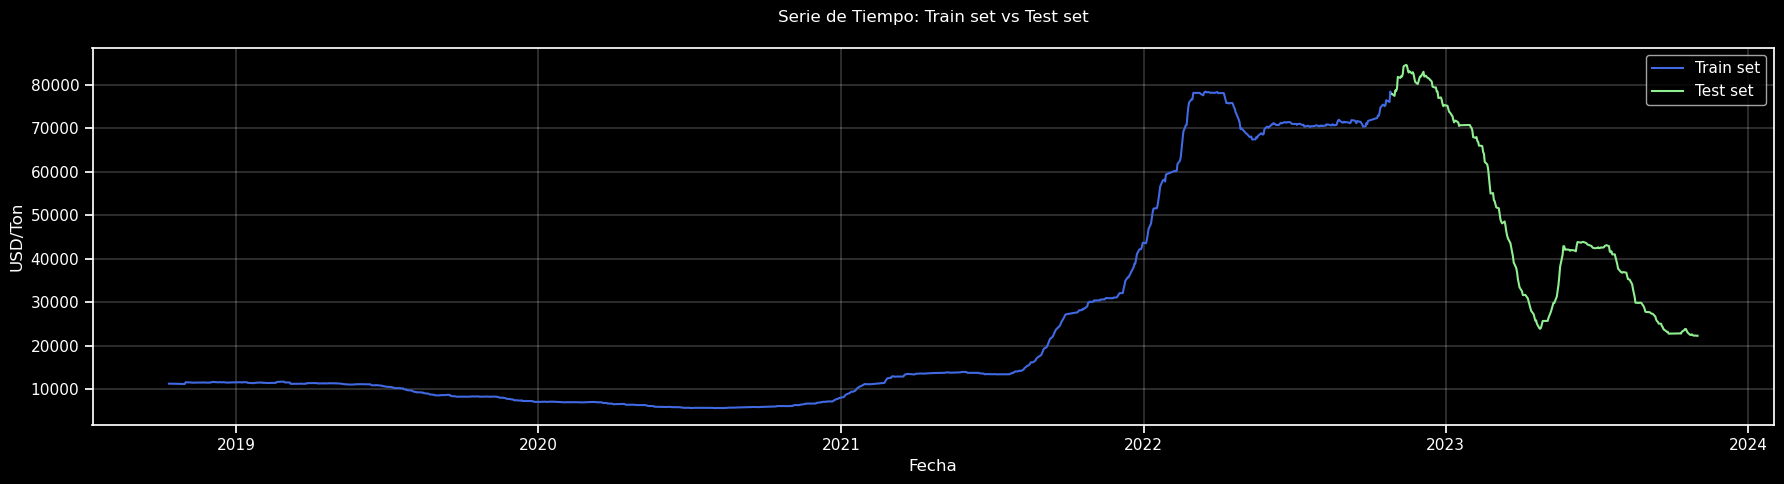

In [10]:
# Graficamos los datos de entrenamiento y prueba
plotting_train_test_pred(train_data=data.loc[:fin_entrenamiento, target],
                         test_data=data.loc[fin_entrenamiento:, target])

In [11]:
# Modelado
# ==============================================================================
lags_linear = 10
lags_no_linear = 10
steps = 36
seed = 55
tmp_feats = ['month', 'week', 'day_of_week', 'day_of_month', 'year']

# Hiperparámetros de los regresores
param_grid_linear_models = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

param_grid_no_linear_models = {
    'n_estimators': list(range(600, 901, 100)),
    'max_depth': [3, 4],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Lista de regresores empaquetados con sus respectivos diccionarios de hiperparámetros y pipelines
regresores = [
    # Lineales
    (Ridge(random_state=seed), param_grid_linear_models, tmp_feats, pipeline_linear_models),
    (Lasso(random_state=seed), param_grid_linear_models, tmp_feats, pipeline_linear_models),
    (GeneralizedLinearRegressor(random_state=seed), param_grid_linear_models, tmp_feats, pipeline_linear_models),
    
    # No lineales
    (XGBRegressor(random_state=seed, tree_method='gpu_hist', n_jobs=-1), param_grid_no_linear_models, tmp_feats, pipeline_no_linear_models),
    (LGBMRegressor(random_state=seed, verbose=-1, n_jobs=-1), param_grid_no_linear_models, tmp_feats, pipeline_no_linear_models)
]

# Inicialización del diccionario de resultados
resultados = dict()

for model, param_grid, tmp, pipeline in regresores:
    # Ingeniería de variables
    # ==============================================================================
    data_transformada = pipeline(data=data, tmp=tmp, target=target, n_windows=10)
    variables_exogenas = [var for var in data_transformada.columns if var != target]
    
    # Forecaster
    # ==============================================================================
    if isinstance(model, (Ridge, Lasso, GeneralizedLinearRegressor)):
        forecaster = ForecasterAutoreg(
            regressor=model,
            lags=lags_linear,
            transformer_y=StandardScaler()
        )
    
        # Búsqueda de lags para el componente autorregresivo
        lags_grid = list(range(1, lags_linear+1))    
        
    else:
        forecaster = ForecasterAutoreg(
            regressor=model,
            lags=lags_no_linear,
            differentiation=1
        )
        
        # Búsqueda de lags para el componente autorregresivo
        lags_grid = list(range(1, lags_no_linear+1))
    
    # Búsqueda en grilla de hiperparámetros y lags
    # ==============================================================================
    resultados_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = data_transformada.loc[:, target], # Datos entrenamiento y validación
                            exog               = data_transformada.loc[:, variables_exogenas], # Variables exógenas utilizadas en cada iteración
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = steps, # Número de pasos hacia adelante optimizando el modelo durante la búsqueda de la mejor combinación de parámetros
                            refit              = False,
                            metric             = 'mean_absolute_error',
                            initial_train_size = data_transformada.loc[:fin_entrenamiento, target].shape[0], # El modelo se entrena con los datos de entrenamiento
                            return_best        = True,
                            n_jobs             = -1,
                            verbose            = False,
                            fixed_train_size   = False,
                            show_progress      = False
)
    
    # Backtesting datos de validación
    # ==============================================================================
    mae, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data_transformada.loc[:, target], # Datos entrenamiento y validación
                            exog               = data_transformada.loc[:, variables_exogenas], # Variables exógenas utilizadas en cada iteración
                            initial_train_size = data_transformada.loc[:fin_entrenamiento, target].shape[0], # El modelo se entrena con los datos de entrenamiento
                            steps              = steps, # La cantidad de pasos hacia adelante que el modelo va a predecir en cada iteración del backtest
                            refit              = False,
                            metric             = 'mean_absolute_error',
                            n_jobs             = -1,
                            interval           = [5, 95],
                            verbose            = False, # True para ver detalles del backtesting
                            fixed_train_size   = False,
                            show_progress      = False                           
)   
    
    # Función de pérdida para medir el rendimiento de los modelos
    # ==============================================================================
    mape, rmse, rmspe, r2 = loss_function(
                        y_true = data_transformada.loc[fin_entrenamiento:, target][1:],
                        y_pred = predicciones['pred']
)
    
    # Almacenar las predicciones y las métricas al Dataframe de rendimientos
    # ==============================================================================
    nuevo_rendimiento = pd.DataFrame({
        'Modelo': [type(model).__name__],
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'RMSPE': rmspe,
        'R²': r2,
        'exog': [True]
    })
    
    # Actualizamos los rendimientos de los modelos
    rendimiento = pd.concat([rendimiento, nuevo_rendimiento], ignore_index=True)
    
    # Almacenar el nombre del modelo, las predicciones y el objeto del modelo en el diccionario
    resultados[type(model).__name__] = {
        'nombre': type(model).__name__,
        'predicciones': predicciones, # Contiene un diccionario con las predicciones y los intervalos de confianza
        'modelo_objeto': model,
        'forecaster': forecaster,
        'vars_exog': data_transformada
    }

Number of models compared: 50.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 527.2880059963749

Number of models compared: 50.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 6118.909375009072

Number of models compared: 50.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8 9] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 876.5511706171732

Number of models compared: 240.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 900}
  Backtesting metric: 4740.806447038091

Number of models compared: 240.
`Forecaster` refitted using the best-found lags and parame

In [12]:
# Rendimiento de los modelos
# ==============================================================================
# Ordenamos de acuerdo a las métricas de nuestro interés
df_rendimiento = rendimiento.sort_values(by=['RMSE', 'MAE', 'RMSPE', 'MAPE', 'R²']).set_index('Modelo')

# Ajustar nombres de columnas e índices
df_rendimiento.columns.name = None
df_rendimiento.index.name = None
df_rendimiento

,MAE,MAPE,RMSE,RMSPE,R²,exog
Random Walk,261.7517,0.0094,370.6776,0.0134,0.9987,False
Ridge,527.2880,0.0124,716.7374,0.0173,0.9988,True
GeneralizedLinearRegressor,876.5512,0.0211,"1,160.3061",0.0292,0.9969,True
XGBRegressor,"4,740.8064",0.1177,"7,738.6429",0.1944,0.8611,True
Lasso,"6,118.9094",0.1546,"7,766.0469",0.2002,0.8601,True
LGBMRegressor,"5,632.3092",0.1440,"8,364.6693",0.2152,0.8377,True


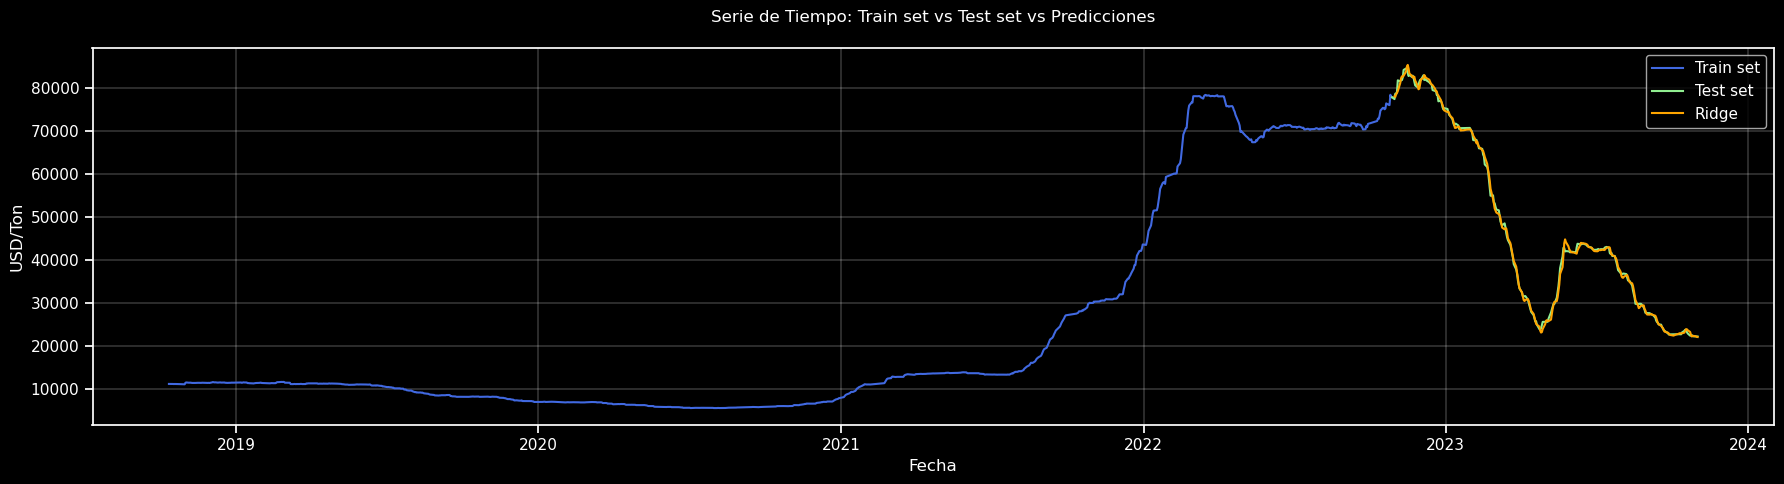

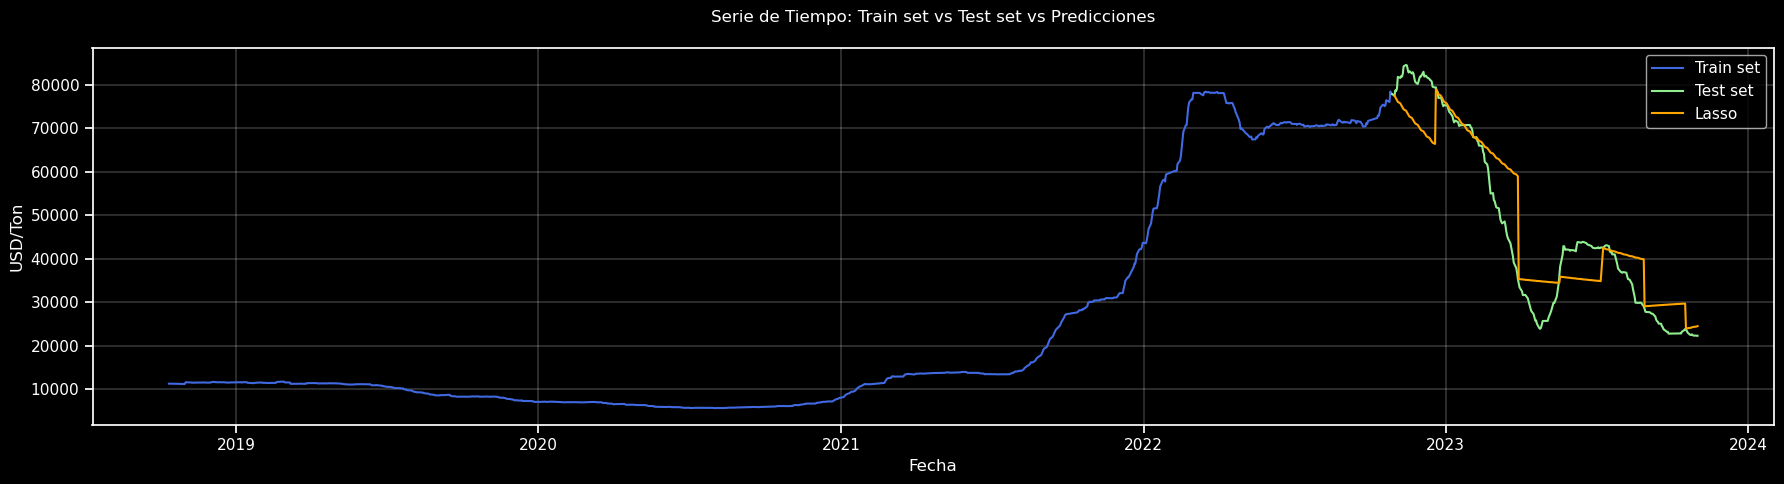

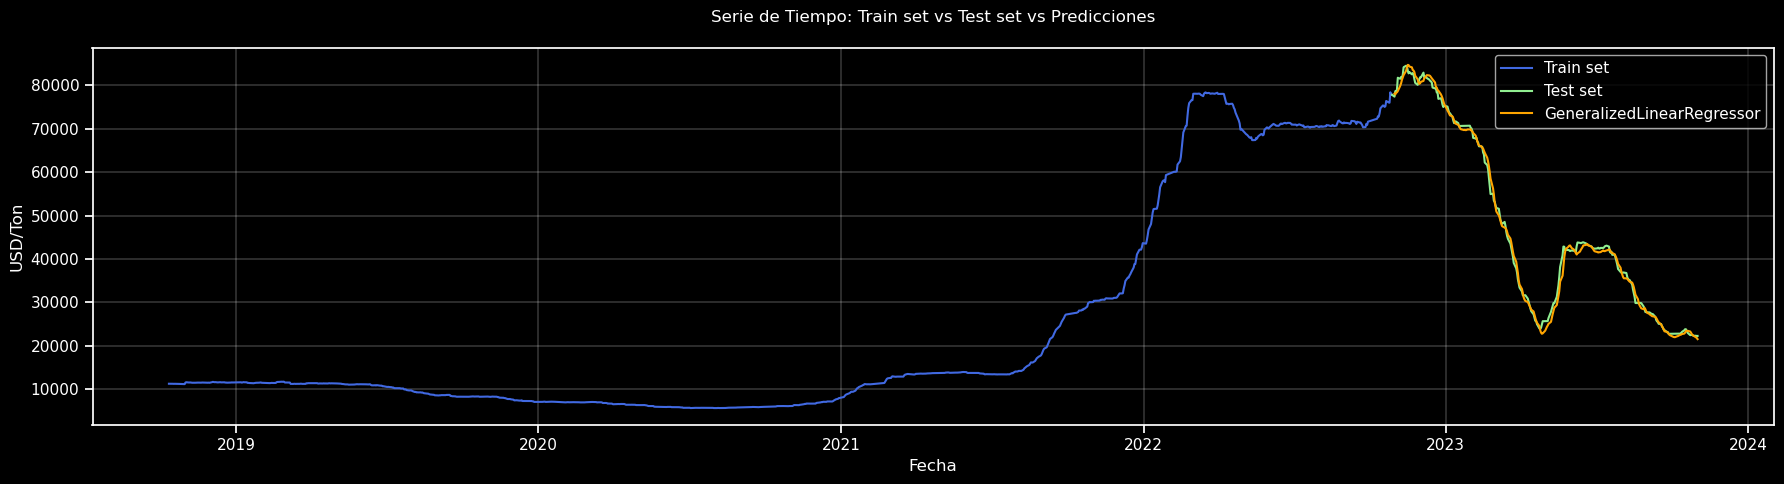

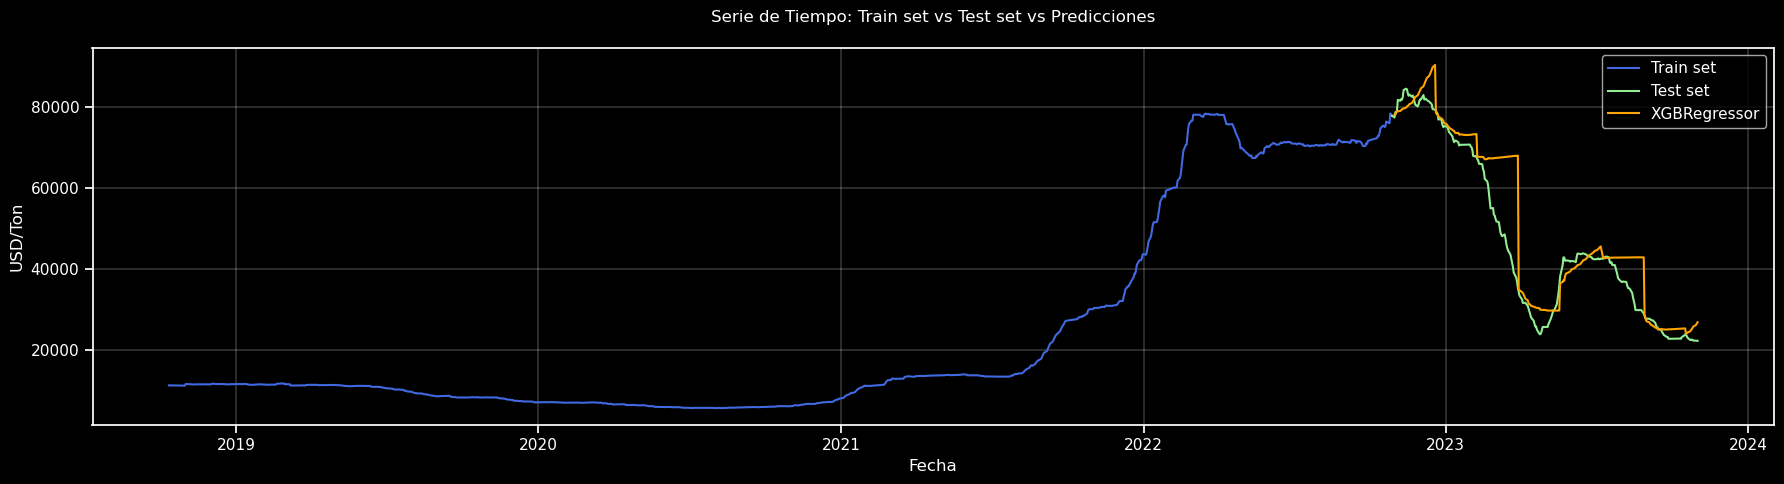

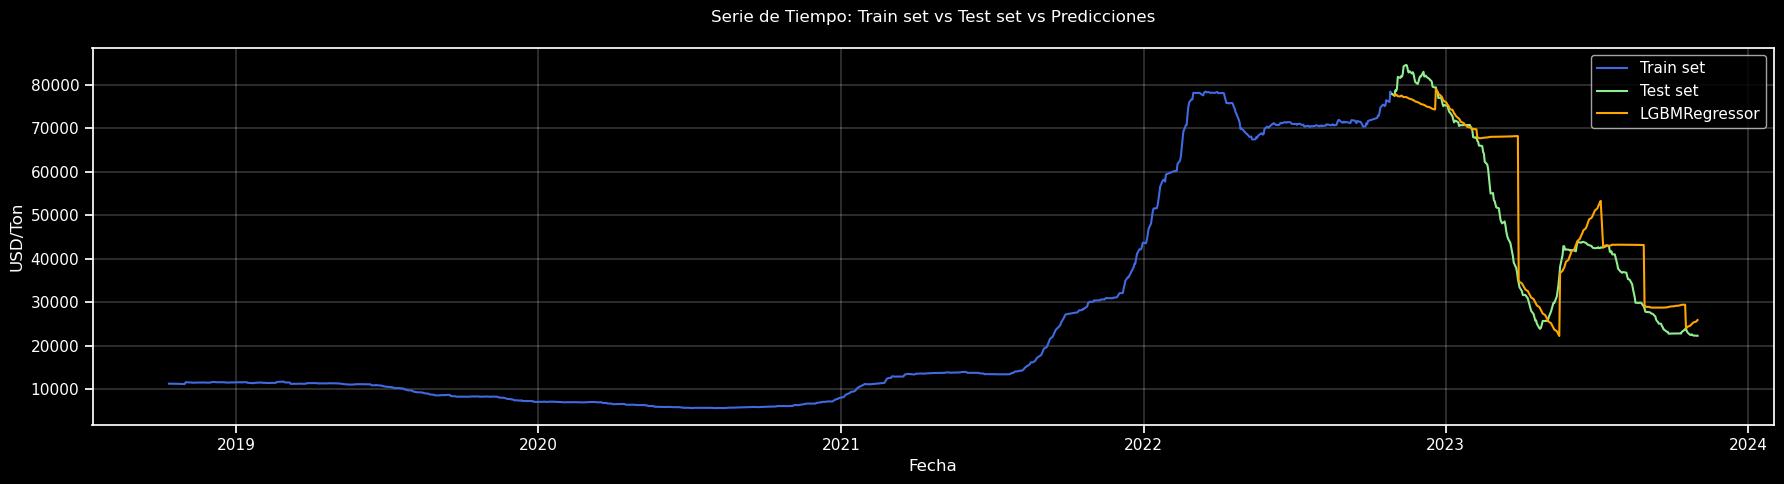

In [13]:
# Resultados
# ==============================================================================
for name, model_data in resultados.items():
    plotting_train_test_pred(train_data=data.loc[:fin_entrenamiento, target],
                             test_data=data.loc[fin_entrenamiento:, target],
                             modelo=model_data['modelo_objeto'],
                             preds_data=model_data['predicciones']['pred'])

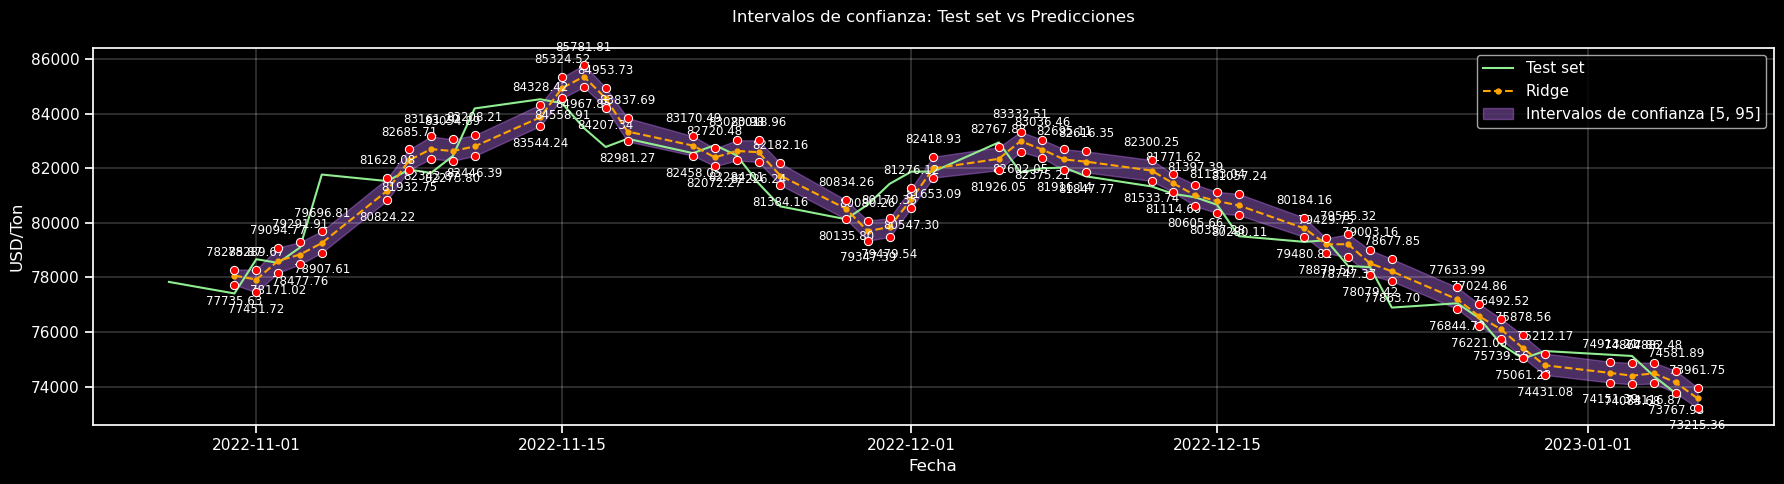

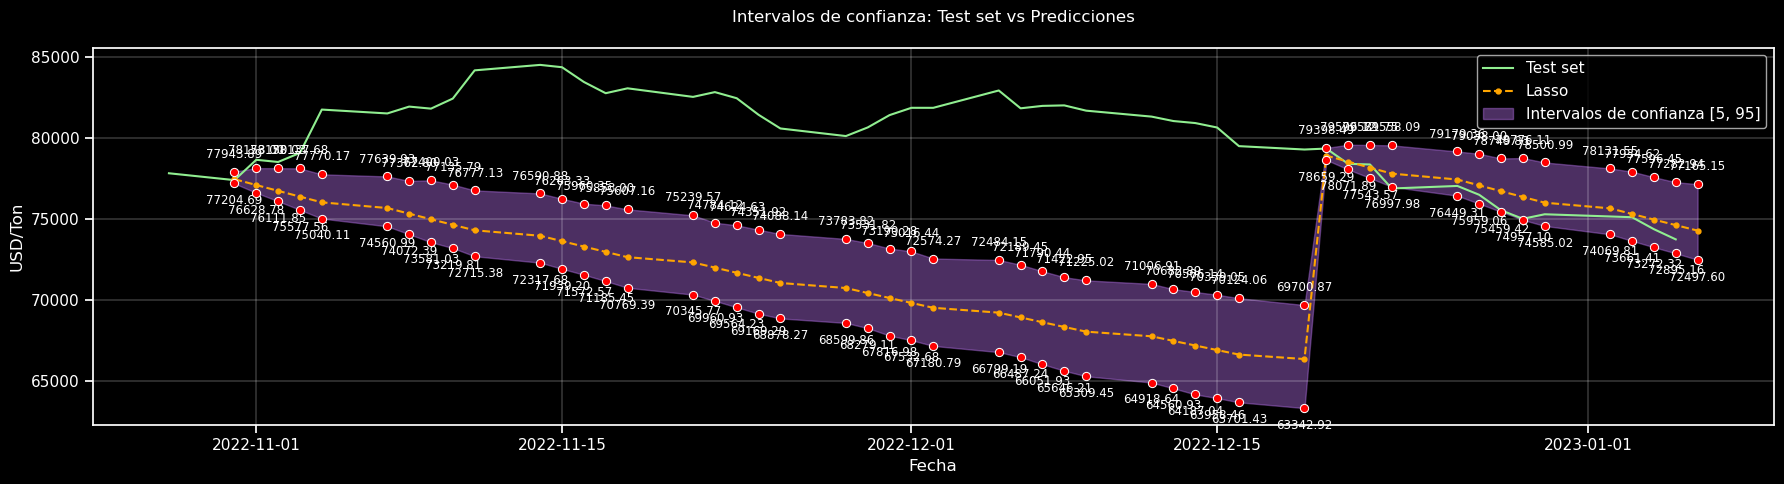

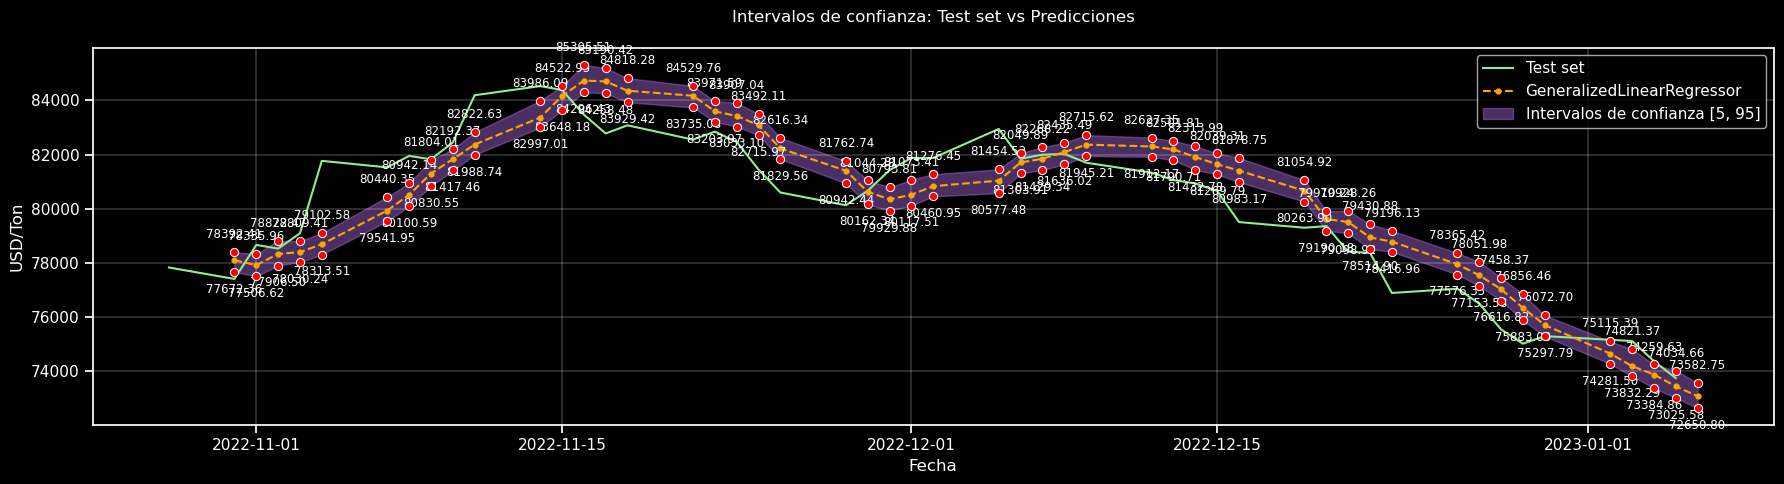

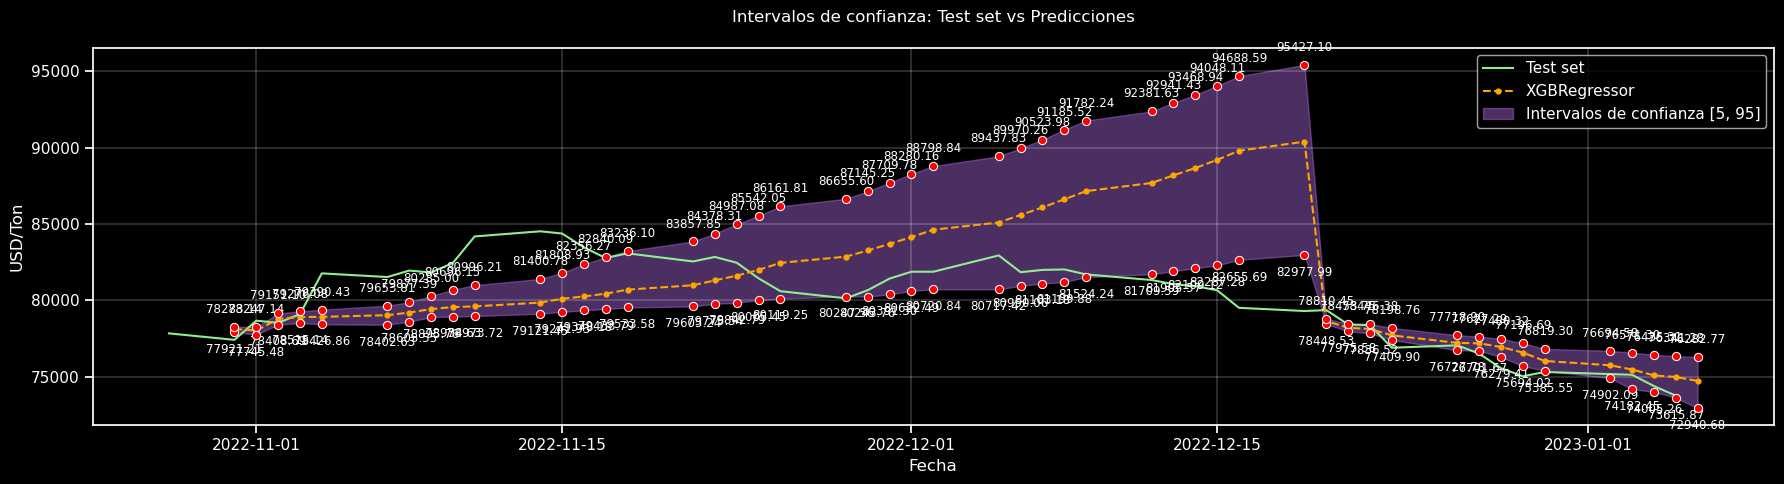

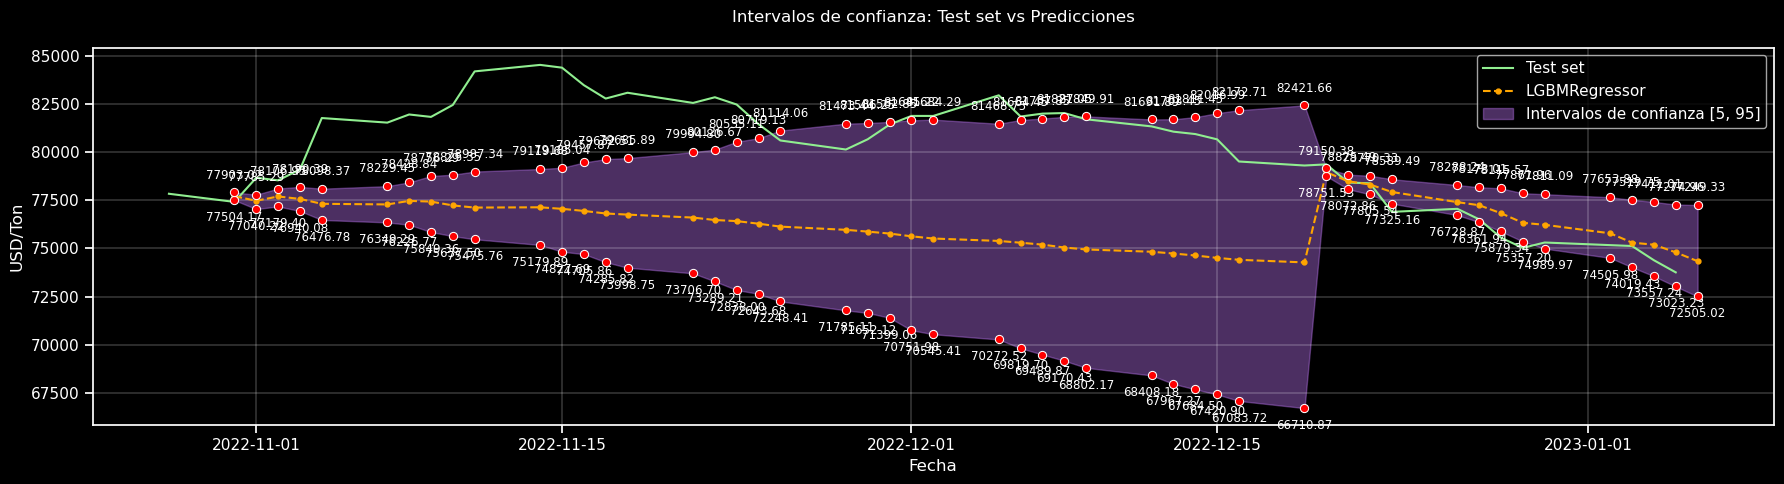

In [14]:
# Intervalos de confianza en el limite 5 y 95
# ==============================================================================
for name, model_data in resultados.items():
    plotting_confidence_intervals_preds(test_data=data.loc[fin_entrenamiento:, target][:50],
                                        modelo=model_data['modelo_objeto'],
                                        preds_data=model_data['predicciones']['pred'][:50],
                                        intervals_preds=model_data['predicciones'][:50])

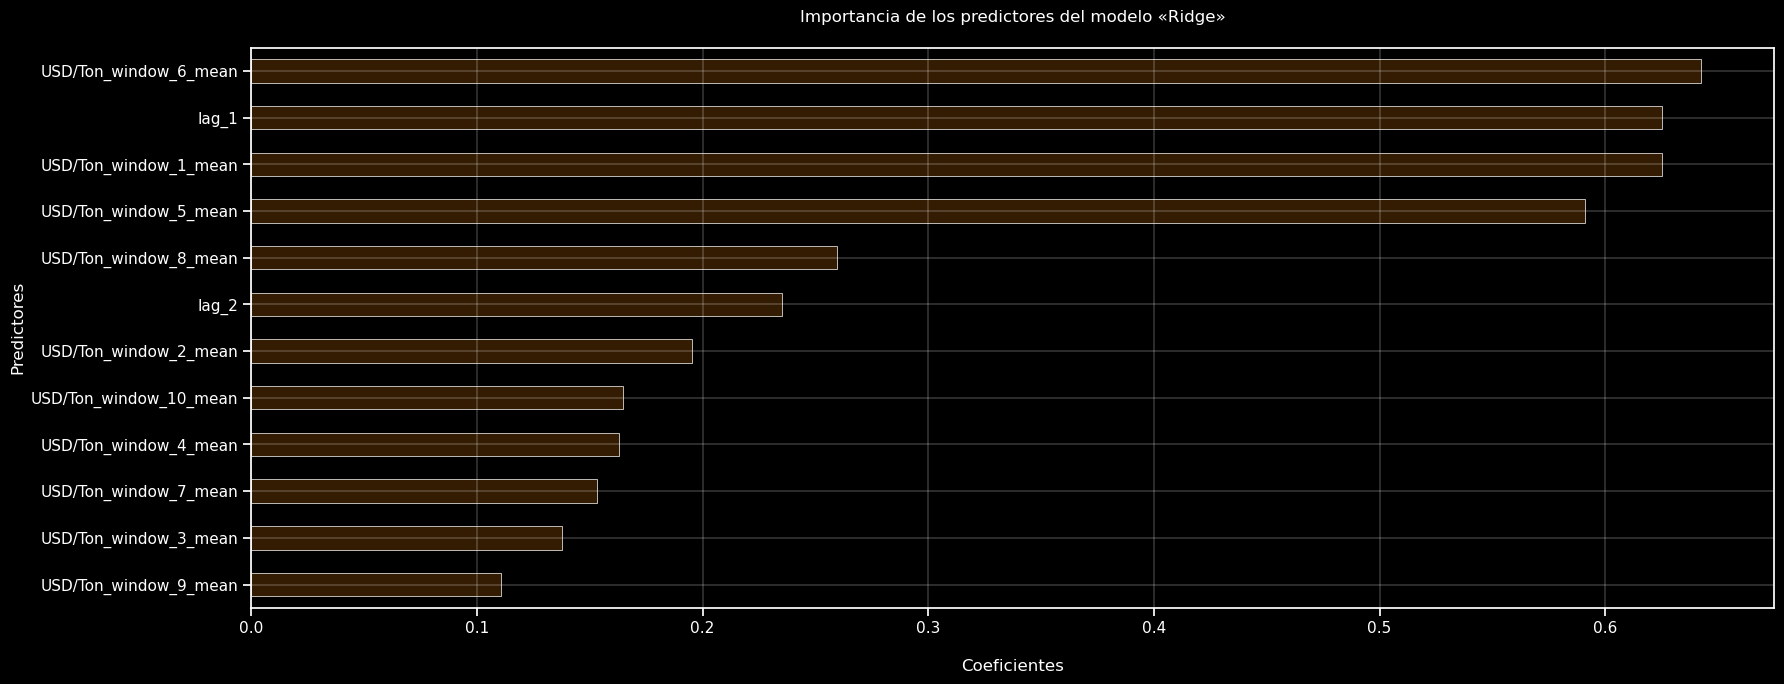

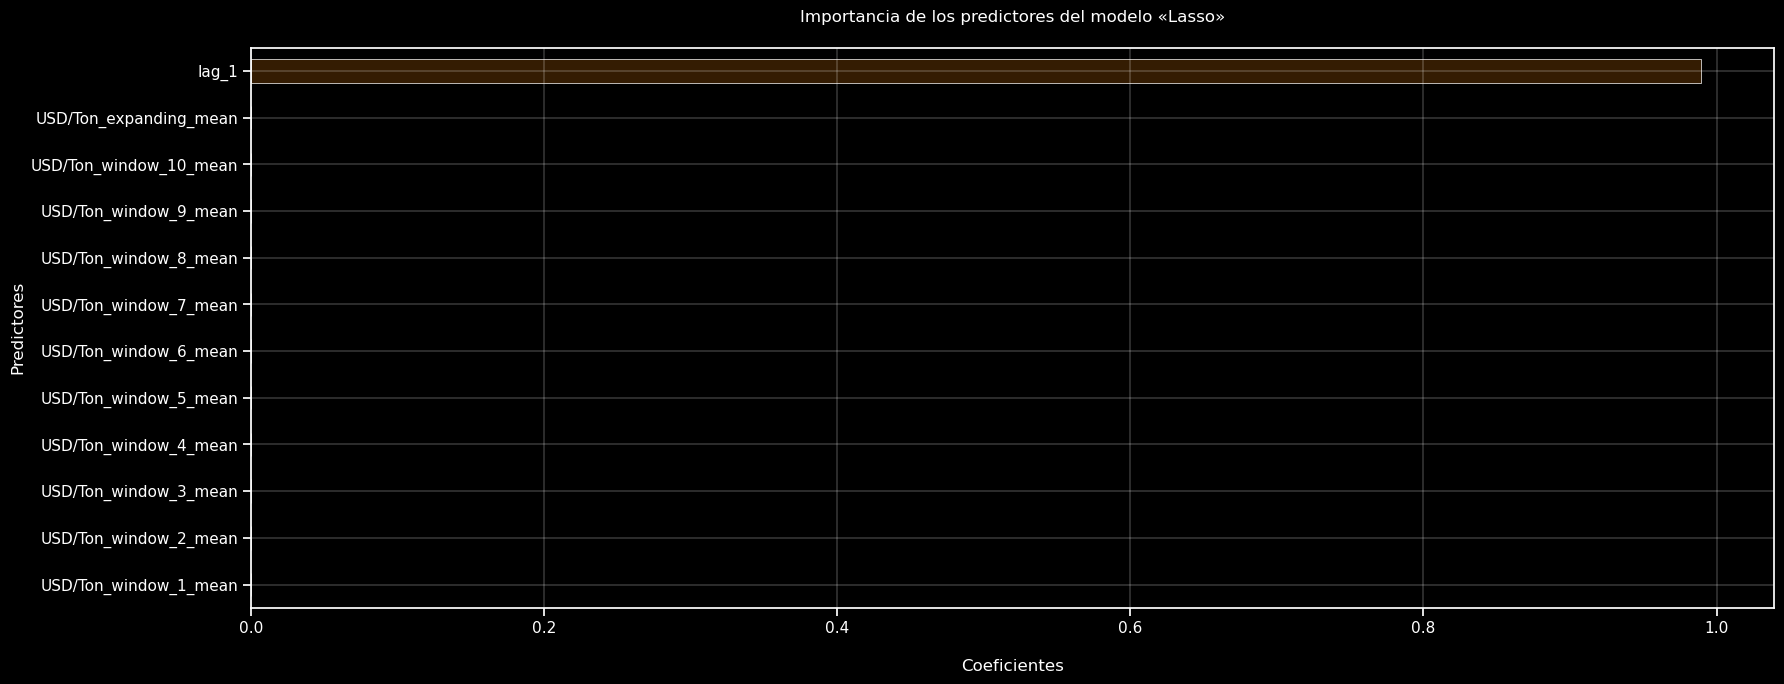

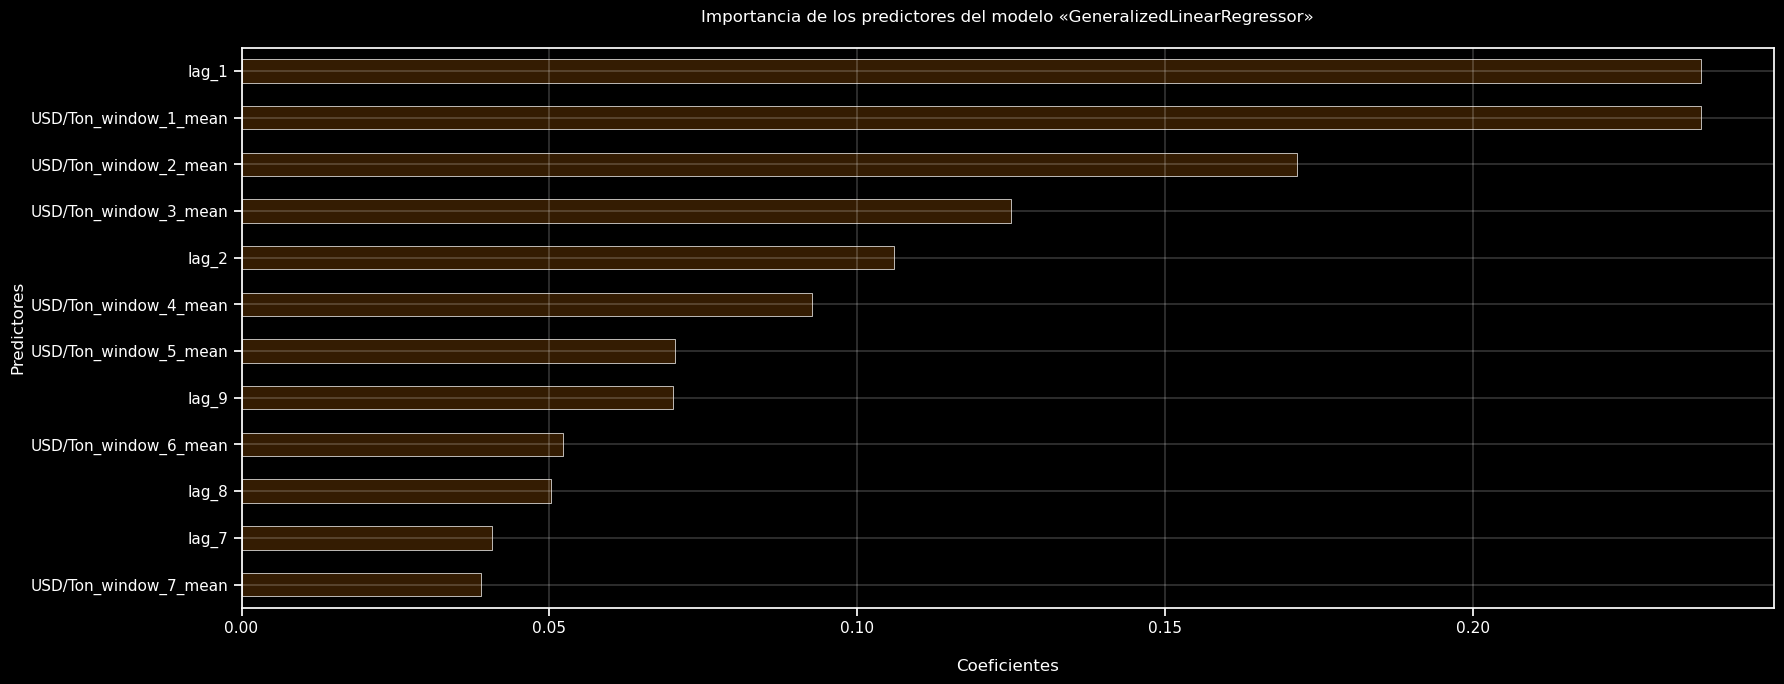

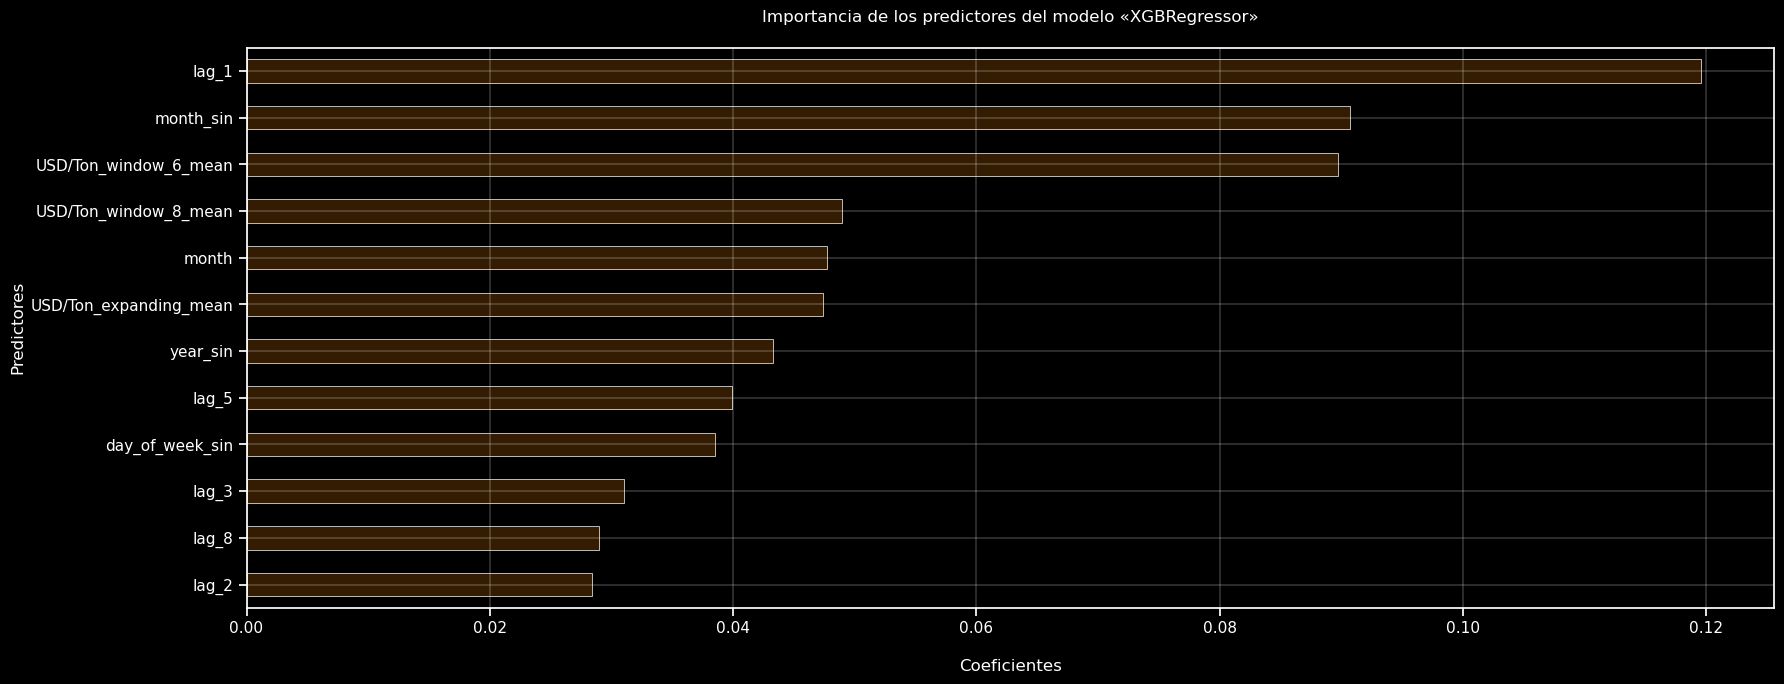

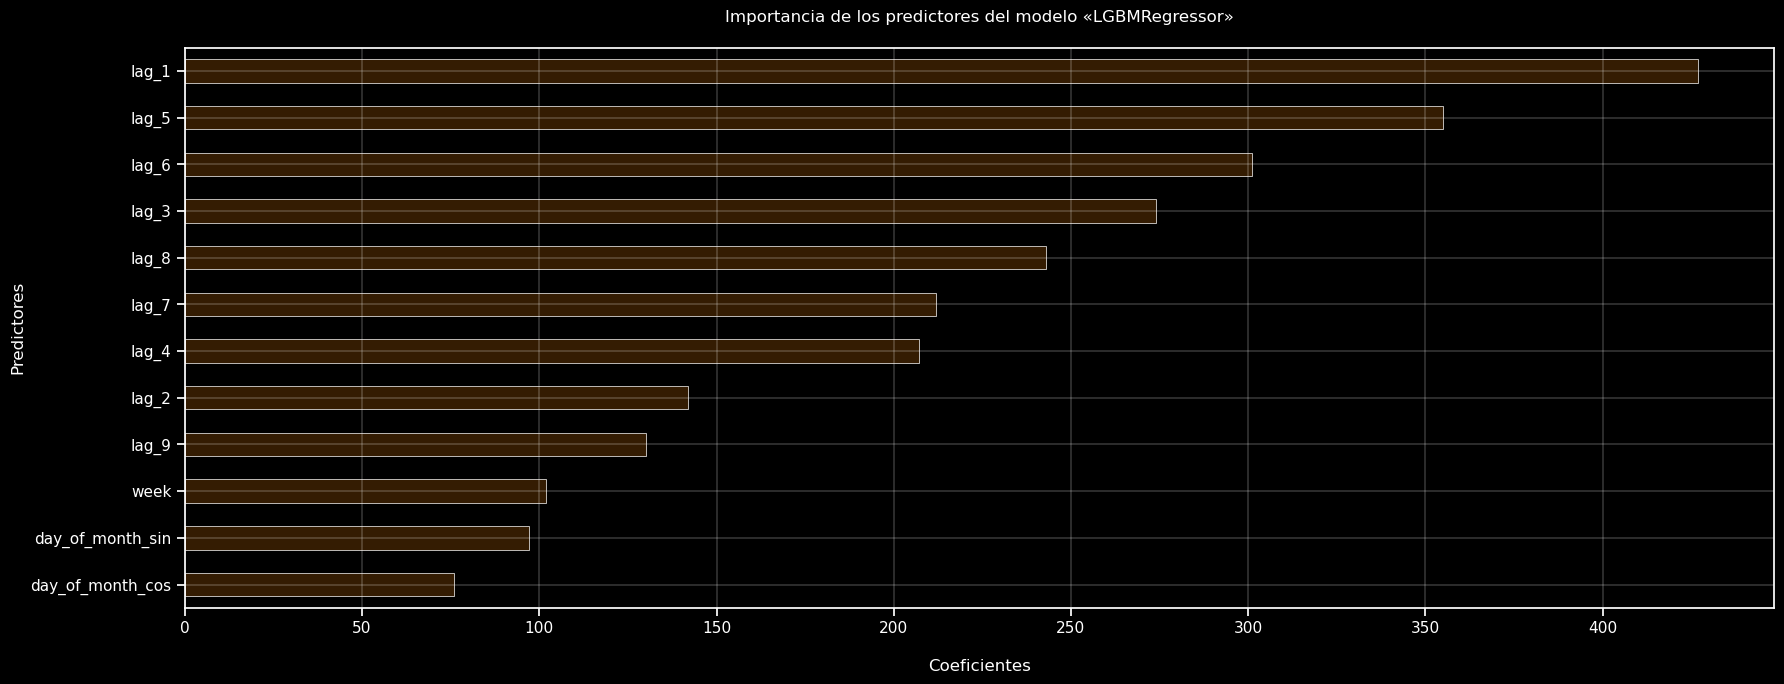

In [15]:
# Importancia de los predictores del modelo
# ==============================================================================
for model_name in resultados.keys():
    importances = resultados[model_name]['forecaster'].get_feature_importances()
    
    # Si no hay importancias o el DataFrame está vacío, imprime un mensaje y continua con el siguiente modelo
    if importances is None or importances.empty:
        continue
    
    # Si hay importancias, procedemos a graficar
    importances['importance'] = importances['importance'].abs()
    importances = importances.nlargest(12, 'importance').sort_values('importance')
    
    importances.set_index('feature', inplace=True)
    importances.plot.barh(
        figsize=(18, 7), 
        color='xkcd:dark brown', 
        width=0.5,
        edgecolor='white', 
        lw=0.5, 
        legend=False
    )

    # Agregar etiquetas y títulos
    plt.title(f'Importancia de los predictores del modelo «{model_name}»\n')
    plt.xlabel('\nCoeficientes')
    plt.ylabel('Predictores')
    plt.grid(color='white', linestyle='-', linewidth=0.25)
    plt.tight_layout()
    plt.show()


In [16]:
# Revisamos los datos de entrada y el target del mejor modelo
# ==============================================================================
best_model = resultados[df_rendimiento.index[1]]
data_transformada = best_model['vars_exog']

X_train, y_train = best_model['forecaster'].create_train_X_y(
                        y = data_transformada.loc[:fin_entrenamiento, target],
                        exog = data_transformada.loc[:fin_entrenamiento, data_transformada.columns])
X_train

,lag_1,lag_2,USD/Ton,USD/Ton_window_1_mean,USD/Ton_window_2_mean,USD/Ton_window_3_mean,USD/Ton_window_4_mean,USD/Ton_window_5_mean,USD/Ton_window_6_mean,USD/Ton_window_7_mean,USD/Ton_window_8_mean,USD/Ton_window_9_mean,USD/Ton_window_10_mean,USD/Ton_expanding_mean,month_sin,month_cos,month_10,month_11,month_12,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_53,day_of_week_4,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_month_12,day_of_month_15,day_of_month_16,day_of_month_17,day_of_month_18,day_of_month_19,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_29,day_of_month_30,day_of_month_31,day_of_month_1,day_of_month_2,day_of_month_5,day_of_month_6,day_of_month_7,day_of_month_8,day_of_month_9,day_of_month_13,day_of_month_14,day_of_month_20,day_of_month_21,day_of_month_27,day_of_month_28,day_of_month_3,day_of_month_4,day_of_month_10,day_of_month_11,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023
Fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-30,-0.5063,-0.5051,"11,195.1500",-0.6696,-0.6689,-0.6686,-0.6683,-0.6680,-0.6678,-0.6675,-0.6673,-0.6671,-0.6667,-0.4958,-0.8660,0.5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2018-10-31,-0.5067,-0.5063,"11,181.5100",-0.6700,-0.6696,-0.6690,-0.6687,-0.6684,-0.6680,-0.6679,-0.6675,-0.6673,-0.6671,-0.4963,-0.8660,0.5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2018-11-01,-0.5072,-0.5067,"11,554.5200",-0.6705,-0.6701,-0.6697,-0.6691,-0.6688,-0.6684,-0.6681,-0.6679,-0.6676,-0.6674,-0.4969,-0.5000,0.8660,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2018-11-02,-0.4920,-0.5072,"11,609.5100",-0.6560,-0.6631,-0.6651,-0.6660,-0.6662,-0.6664,-0.6664,-0.6663,-0.6663,-0.6662,-0.4940,-0.5000,0.8660,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2018-11-05,-0.4898,-0.4920,"11,551.0100",-0.6538,-0.6547,-0.6597,-0.6620,-0.6633,-0.6639,-0.6643,-0.6645,-0.6646,-0.6648,-0.4909,-0.5000,0.8660,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,2.1485,2.0991,"76,070.4900",1.8701,1.8465,1.8368,1.8347,1.8340,1.8293,1.8196,1.8088,1.8007,1.7921,1.1992,-0.8660,0.5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

In [17]:
# Comparativa entre los datos reales de las predicciones tabularmente
pd.concat([data.loc[fin_entrenamiento:][1:], best_model['predicciones']['pred']], axis=1)

,USD/Ton,pred
2022-10-31,"77,412.7300","78,067.6987"
2022-11-01,"78,667.1200","77,919.8103"
2022-11-02,"78,532.2300","78,606.7564"
2022-11-03,"79,093.3400","78,836.6055"
2022-11-04,"81,766.4300","79,258.3182"
...,...,...
2023-10-26,"22,450.9600","22,375.3641"
2023-10-27,"22,314.4800","22,431.7966"
2023-10-30,"22,317.7500","22,306.9196"
2023-10-31,"22,268.7000","22,204.0064"


---